In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
from scipy.stats import shapiro
from scipy.stats import wilcoxon

In [37]:

models = ['Random Forest', 'Naive Bayes', 'SVC', 'MLP','Baseline']


F1_metrics = []
for model in models:
    with open(f'metrics/{model}_F1.pkl', 'rb') as f:
        F1_metrics.append(content:=pickle.load(f))
log_F1_metrics = [np.log1p(metric) for metric in F1_metrics]

MSE_metrics = []
for model in models:
    with open(f'metrics/{model}.pkl', 'rb') as f:
        MSE_metrics.append(content:=pickle.load(f))
log_MSE_metrics = [np.log(metric) for metric in MSE_metrics]



shapiro_results = []
for i, (mse_, f1_) in enumerate(zip(MSE_metrics, F1_metrics)):
    mse_stat, mse_p = shapiro(mse_)
    f1_stat, f1_p = shapiro(f1_)

    shapiro_results.append({
        'Model': models[i], 'MSE Shapiro-Wilk Test p-value': mse_p, 'WF1 Shapiro-Wilk Test p-value': f1_p})
shapiro_results = pd.DataFrame(shapiro_results)
shapiro_results.to_latex('tables/MSE_WF1_nolog.txt', index=False, float_format='%.3e')

shapiro_results = []
for i, (log_mse_, log_f1_) in enumerate(zip(log_MSE_metrics, log_F1_metrics)):
    log_mse_stat, log_mse_p = shapiro(log_mse_)
    log_f1_stat, log_f1_p = shapiro(log_f1_)
    shapiro_results.append({
        'Model': models[i], 'Log MSE Shapiro-Wilk Test p-value': log_mse_p, 'Log WF1 Shapiro-Wilk Test p-value': log_f1_p})
shapiro_results = pd.DataFrame(shapiro_results)
shapiro_results.to_latex('tables/MSE_WF1_log.txt', index=False, float_format='%.3e')
shapiro_results

,Model,Log MSE Shapiro-Wilk Test p-value,Log WF1 Shapiro-Wilk Test p-value
0,Random Forest,1.036001e-16,1.753306e-20
1,Naive Bayes,8.041591e-35,7.616663e-33
2,SVC,8.648837e-27,4.111858e-31
3,MLP,3.755482e-16,1.173745e-16
4,Baseline,6.459374e-36,3.092172e-45


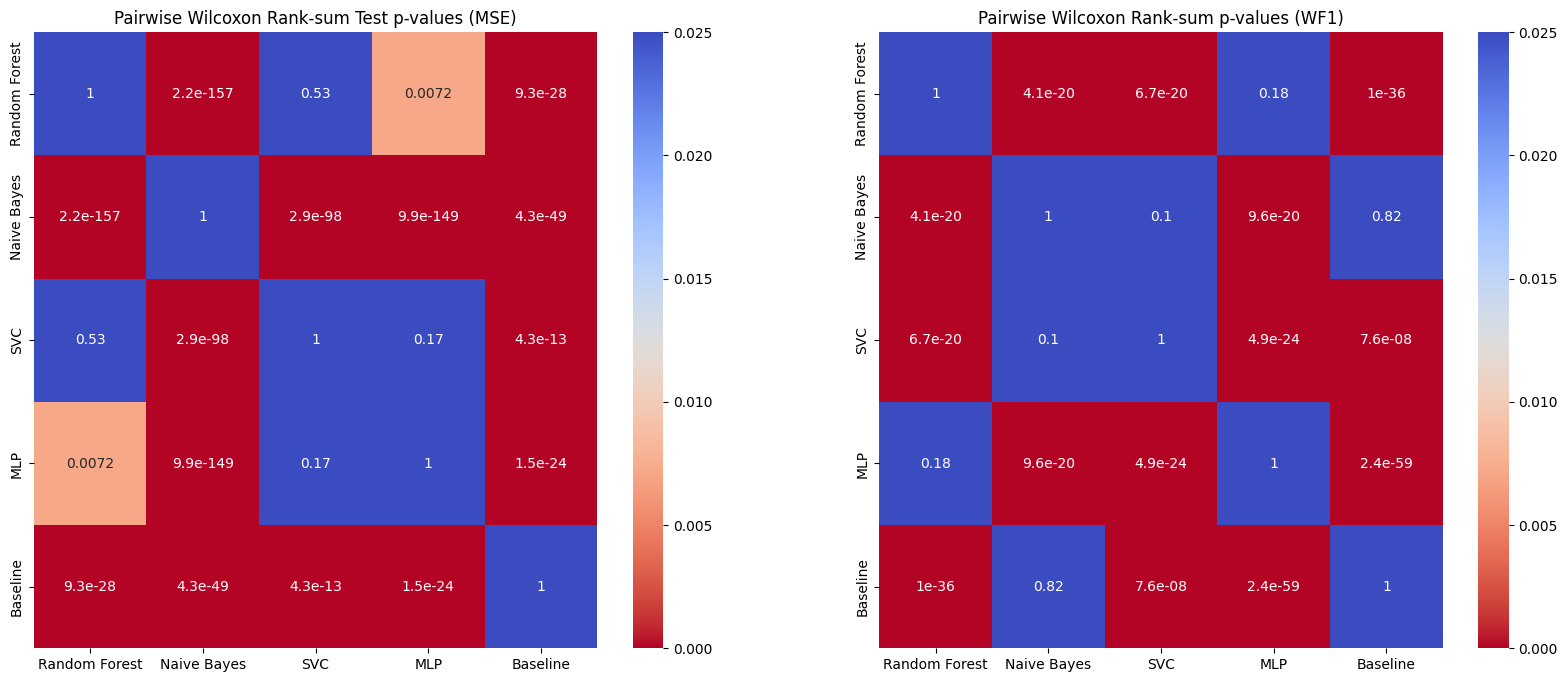

In [38]:
from scipy.stats import ranksums

p_val_matrix_F1 = np.ones((len(models), len(models)))
p_val_matrix_MSE = np.ones((len(models), len(models)))

f1_p_values = []
mse_p_values = []
models_temp = []


for i, metric in enumerate(F1_metrics):
    for j, metric2 in enumerate(F1_metrics):
        if i != j:
            wilcoxon_test = ranksums(metric, metric2)
            p_val_matrix_F1[i, j] = wilcoxon_test.pvalue
            f1_p_values.append(wilcoxon_test.pvalue)
            models_temp.append(models[i] + ' vs ' + models[j])
            


for i, metric in enumerate(MSE_metrics):
    for j, metric2 in enumerate(MSE_metrics):
        if i != j:
            wilcoxon_test = ranksums(metric, metric2)
            p_val_matrix_MSE[i, j] = wilcoxon_test.pvalue
            mse_p_values.append(wilcoxon_test.pvalue)


fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(p_val_matrix_F1, xticklabels=models, yticklabels=models, annot=True, cmap='coolwarm_r', cbar=True, ax=ax[1],
            vmin=0, vmax=0.025)
ax[1].set_title('Pairwise Wilcoxon Rank-sum p-values (WF1)')


sns.heatmap(p_val_matrix_MSE, xticklabels=models, yticklabels=models, annot=True, cmap='coolwarm_r', cbar=True, ax=ax[0],
            vmin=0, vmax=0.025)
ax[0].set_title('Pairwise Wilcoxon Rank-sum Test p-values (MSE)')

plt.savefig('plots/pairwise_wilcoxon_pvalues_comparison.png')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


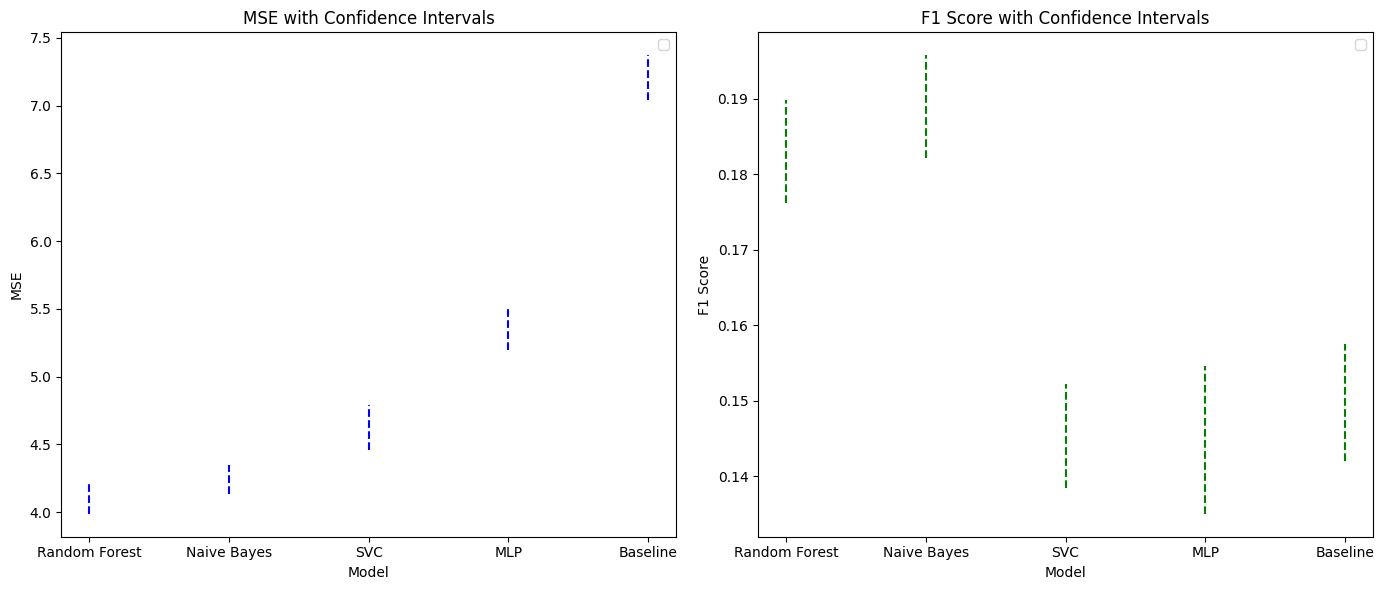

In [39]:
mse_lower_bounds = [3.987314, 4.135893, 4.454701, 5.196415, 7.043152]
mse_upper_bounds = [4.225893, 4.351091, 4.790061, 5.502263, 7.371313]
mse_means = [4.104940, 4.242143, 4.619048, 5.351190, 7.208333]
mse_std_devs = [2.252427, 2.067832, 3.168658, 2.943950, 3.155486]

f1_lower_bounds = [0.176162, 0.182192, 0.138531, 0.135058, 0.142109]
f1_upper_bounds = [0.189803, 0.195738, 0.152298, 0.154664, 0.157470]
f1_means = [0.182946, 0.188940, 0.145293, 0.144824, 0.149881]
f1_std_devs = [0.130141, 0.129482, 0.132876, 0.188260, 0.147049]

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# MSE plot
# ax1.errorbar(models, mse_means, yerr=mse_std_devs, fmt='o', capsize=5, label='MSE Mean')
for i in range(len(models)):
    ax1.plot([models[i], models[i]], [mse_lower_bounds[i], mse_upper_bounds[i]], color='blue', linestyle='--')
ax1.set_title('MSE with Confidence Intervals')
ax1.set_xlabel('Model')
ax1.set_ylabel('MSE')
ax1.legend()

# F1 plot

for i in range(len(models)):
    ax2.plot([models[i], models[i]], [f1_lower_bounds[i], f1_upper_bounds[i]], color='green', linestyle='--')
ax2.set_title('F1 Score with Confidence Intervals')
ax2.set_xlabel('Model')
ax2.set_ylabel('F1 Score')
ax2.legend()

plt.tight_layout()
plt.show()

In [40]:
FWER = 1- (1-0.005)**10
FWER

0.048889869534228136

In [46]:
sorted_f1_p_values = sorted(f1_p_values)
q = 0.1
m = 10
for i, pval in enumerate(sorted_f1_p_values):
    if i % 2 == 0:
        print(((i+1)/m)*q > pval, pval)

True 2.363374853871566e-59
True 1.0068854781248423e-36
True 4.858087576303633e-24
True 4.132366465043444e-20
True 6.654934794469333e-20
True 9.600147784677539e-20
True 7.592565917034373e-08
True 0.10176803081476248
False 0.17534052469663697
False 0.8151688646970219


In [47]:
sorted_mse_p_values = sorted(mse_p_values)
q = 0.1
m = 10
for i, pval in enumerate(sorted_mse_p_values):
    if i % 2 == 0:
        print(((i+1)/m)*q > pval, pval)

True 2.1971975728293223e-157
True 9.88967435045735e-149
True 2.9033070916555707e-98
True 4.319840904919213e-49
True 9.344115439151326e-28
True 1.498842544120676e-24
True 4.2718261174875955e-13
True 0.007204857318020609
False 0.1700044072968766
False 0.530996726671175


In [43]:
f1_medians = [np.median(f1) for f1 in F1_metrics]
mse_medians = [np.median(mse) for mse in MSE_metrics]

models, f1_medians, mse_medians

pd.DataFrame({'Model': models, 'F1 Median': f1_medians, 'MSE Median': mse_medians})#.to_latex('tables/medians.txt', index=False, float_format='%.3e', bold_rows=True)

,Model,F1 Median,MSE Median
0,Random Forest,0.165476,3.833333
1,Naive Bayes,0.104167,6.583333
2,SVC,0.113757,3.250000
3,MLP,0.157407,3.916667
4,Baseline,0.100000,4.875000


C:\Users\pvest\AppData\Local\Temp\ipykernel_34452\4003684233.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='F1 Score', data=df_F1, palette='Set1', ax=ax[1])
C:\Users\pvest\AppData\Local\Temp\ipykernel_34452\4003684233.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='MSE', data=df_MSE, palette='Set1', ax=ax[0])


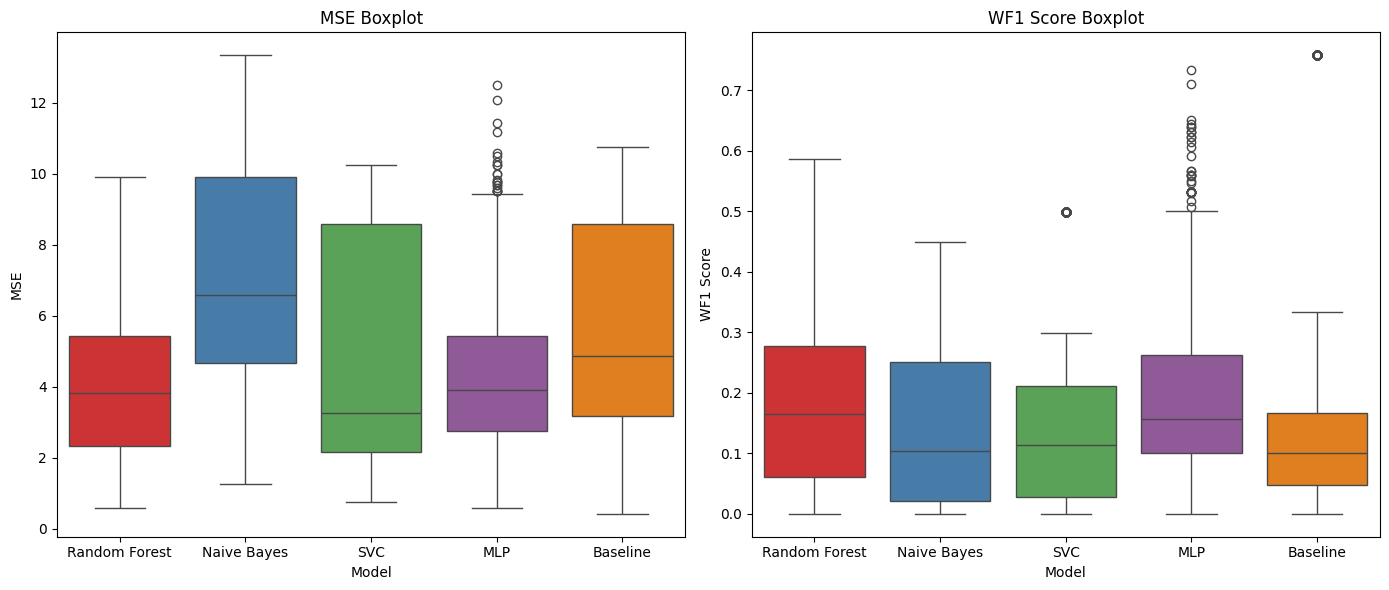

In [44]:
df_F1 = pd.DataFrame(F1_metrics, index=models).T.melt(var_name='Model', value_name='F1 Score')
df_MSE = pd.DataFrame(MSE_metrics, index=models).T.melt(var_name='Model', value_name='MSE')


fig, ax = plt.subplots(1, 2, figsize=(14, 6))


sns.boxplot(x='Model', y='F1 Score', data=df_F1, palette='Set1', ax=ax[1])
ax[1].set_title('WF1 Score Boxplot')
ax[1].set_ylabel('WF1 Score')


sns.boxplot(x='Model', y='MSE', data=df_MSE, palette='Set1', ax=ax[0])
ax[0].set_title('MSE Boxplot')
ax[0].set_ylabel('MSE')

plt.tight_layout()
plt.savefig('plots/boxplots_colored.png')
plt.show()

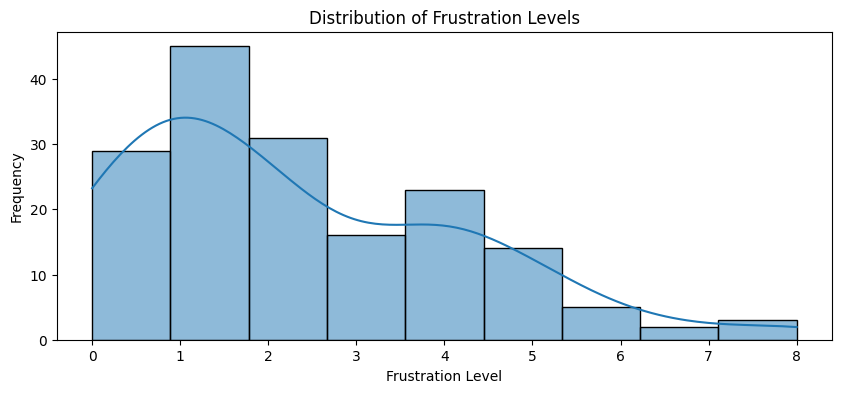

In [45]:
import pandas as pd
new_df = pd.read_csv('data/HR_data.csv', index_col=0)
new_df
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
sns.histplot(new_df['Frustrated'], kde=True)
plt.title('Distribution of Frustration Levels')
plt.xlabel('Frustration Level')
plt.ylabel('Frequency')
plt.savefig('plots/frustration_distribution.png')
plt.show()